Load in all the motion-corrected volumes into a single runs x TRs x voxels array

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import nilearn
import nilearn.masking

In [ ]:
%pip install git+https://github.com/cvnlab/GLMsingle.git

In [62]:
from glmsingle.glmsingle import GLM_single

In [58]:
import numpy as np
from scipy import stats
import utils_mindeye

try:
    with open('conf/config.json', 'r') as f:
        config = json.load(f)
    storage_path = config['storage_path']
    data_path = config['data_path']
    derivatives_path = config['derivatives_path']
    fsl_path = config['fsl_path']
    assert os.path.exists(storage_path), "The specified data and model storage path does not exist."
    assert os.path.exists(data_path), "The specified BOLD path does not exist."
    assert os.path.exists(derivatives_path), "The specified derivatives path does not exist."
    assert os.path.exists(fsl_path), "The specified FSL path does not exist."
except FileNotFoundError:
    raise FileNotFoundError("config.json file not found. Please create it with the required paths.")


betas_path = f'{data_path}/testing/sub-005_ses-03_task-C_bs24_MST_rishab_MSTsplit_union_mask_0_vox.npy'
offline_betas_norm = np.load(betas_path)

In [4]:
mc_dir = '/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/derivatives/motion_corrected_resampled'
n_runs = 11
tr_length = 1.5

In [5]:
mc_vols = np.zeros(shape=(n_runs, 191, 76, 90, 74))
for i in range(n_runs):
    for tr in range(191):
        tmp = nib.load(os.path.join(mc_dir, f'ses-03_run-{i+1:02d}_{tr:04d}_mc_boldres.nii.gz'))
        tmp = tmp.get_fdata()
        assert tmp.shape == (76, 90, 74)
        mc_vols[i, tr] = tmp

In [6]:
mc_vols.shape

(11, 191, 76, 90, 74)

In [17]:
# nilearn.masking.apply_mask(nib.Nifti1Image(mc_vols[0].transpose(1,2,3,0), affine=union_mask_img.affine), union_mask_img).shape

In [18]:
# load fmriprepped data
fmriprep_data_path = '/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/data/testing'
fmriprep_data = []

for run in range(n_runs):
    tmp = nib.load(f'{fmriprep_data_path}/sub-005_ses-03_task-C_run-{run+1:02d}_space-T1w_desc-preproc_bold.nii.gz')
    fmriprep_data.append(tmp)

fmriprep_data = np.array(fmriprep_data)
print(fmriprep_data.shape)

# load union mask
data_path = "/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/data"
union_mask = np.load(f"{data_path}/union_mask_from_ses-01-02.npy")
mask_img = nib.load(f'{data_path}/sub-005_final_mask.nii.gz')  # nsdgeneral mask in functional space

mask_data = mask_img.get_fdata().astype(bool)

# Flatten only the True voxels in the mask
true_voxel_indices = np.where(mask_data.ravel())[0]

# Apply the union_mask (boolean mask of size 19174)
selected_voxel_indices = true_voxel_indices[union_mask]

# Create a new flattened mask with all False
new_mask_flat = np.zeros(mask_data.size, dtype=bool)

# Set selected voxels to True
new_mask_flat[selected_voxel_indices] = True

# Reshape back to original 3D shape
new_mask_data = new_mask_flat.reshape(mask_data.shape)

# Create new NIfTI image
union_mask_img = nib.Nifti1Image(new_mask_data.astype(np.uint8), affine=mask_img.affine)

(11,)


In [71]:
fmriprep_data[0].shape

(76, 90, 74, 192)

In [64]:
mc_data = [nib.Nifti1Image(mc_vols[i].transpose(1,2,3,0), affine=union_mask_img.affine) for i in range(n_runs)]
mc_data[0].shape

(76, 90, 74, 191)

In [20]:
# create events file
ndscore_events = [pd.read_csv(f'{data_path}/events/sub-005_ses-03_task-C_run-{run+1:02d}_events.tsv', sep = "\t", header = 0) for run in range(n_runs)]
ndscore_tr_labels = [pd.read_csv(f"{data_path}/events/sub-005_ses-03_task-C_run-{run+1:02d}_tr_labels.csv") for run in range(n_runs)]

In [21]:
def fast_apply_mask(target=None,mask=None):
    return target[np.where(mask == 1)].T

In [63]:
design.shape, mc_data[0].shape
opt = dict()

opt['wantlibrary'] = 0
opt['wantglmdenoise'] = 0
opt['wantfracridge'] = 0
opt['wantfileoutputs'] = [0,0,0,0]
opt['wantmemoryoutputs'] = [0,1,0,0]

glmsingle_obj = GLM_single(opt)
# s = time.time()
results_glmsingle = glmsingle_obj.fit(design=design_list[0][:15], data=func_data[0][:, 0, 0, :15], stimdur=3, tr=tr_length, outputdir=f'{derivatives_path}/glmsingle')
# e = time.time()

# print(e-s)

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [24]:
# results_glmsingle['typeb']['betasmd'][:,0,0].T.shape

In [25]:
# results_glmsingle['typeb']['betasmd'][:,0,0].T.shape

In [26]:
# np.where(design[run][TR]>0)

In [27]:
all_betas = []
for run in range(n_runs):
    print(f"Run {run} started")
    # events_df = ndscore_events[run]
    tr_labels_hrf = ndscore_tr_labels[run]["tr_label_hrf"].tolist()
    # events_df = events_df[events_df['image_name'] != 'blank.jpg']  # must drop blank.jpg after tr_labels_hrf is defined to keep indexing consistent

    for TR in range(192):
        print(f"TR {TR}")
        current_label = tr_labels_hrf[TR]
        print(current_label)
        
        if current_label not in ('blank', 'blank.jpg'):
            if TR > 20:
                results_glmsingle = glmsingle_obj.fit(design=design_list[0][:TR], data=func_data[0][:, 0, 0, :TR], stimdur=3, tr=tr_length, outputdir=f'{derivatives_path}/glmsingle')
                tmp = results_glmsingle['typeb']['betasmd'][:,0,0].T
                # which condition in tmp is the current_label?
                all_betas.append(tmp)

        elif current_label == 'blank.jpg':
            pass
        else:
            assert current_label == 'blank'

In [ ]:
# run nilearn firstlevel glm
from nilearn.glm.first_level import FirstLevelModel

all_betas = []
for run in range(1):
    print(f"Run {run} started")
    events_df = ndscore_events[run]
    tr_labels_hrf = ndscore_tr_labels[run]["tr_label_hrf"].tolist()
    events_df = events_df[events_df['image_name'] != 'blank.jpg']  # must drop blank.jpg after tr_labels_hrf is defined to keep indexing consistent

    for TR in range(192):
        stimulus_trial_counter = np.sum(
            [label != 'blank' for label in tr_labels_hrf[:TR]]
        )  # stimulus_trial_counter is the trial number minus blank trials; this indexes cropped_events which does not contain blank.jpg since we don't model blank trials
        print(f"TR {TR}")
        current_label = tr_labels_hrf[TR]
        print(current_label)
        
        if current_label not in ('blank', 'blank.jpg'):
            # if TR == 183:
            events_df = events_df.copy()
            events_df['onset'] = events_df['onset'].astype(float)

            run_start_time = events_df['onset'].iloc[0]
            events_df = events_df.copy()
            events_df['onset'] -= run_start_time

            cropped_events = events_df[events_df.onset <= TR*tr_length]
            cropped_events = cropped_events.copy()
            print(stimulus_trial_counter)
            print(np.where(cropped_events['trial_number'] == stimulus_trial_counter))
            assert cropped_events['trial_number'].eq(stimulus_trial_counter).any(), "No matching trial_number found in cropped_events"
            cropped_events.loc[:, 'trial_type'] = np.where(cropped_events['trial_number'] == stimulus_trial_counter, "probe", "reference")
            cropped_events = cropped_events.drop(columns=['is_correct', 'image_name', 'response_time', 'trial_number'])

            lss_glm = FirstLevelModel(t_r=tr_length,slice_time_ref=0,hrf_model='glover',
                        drift_model='cosine', drift_order=1,high_pass=0.01,mask_img=union_mask_img,
                        signal_scaling=False,smoothing_fwhm=None,noise_model='ar1',
                        n_jobs=-1,verbose=-1,memory_level=1,minimize_memory=True)

            lss_glm.fit(run_imgs=fmriprep_data[run].slicer[:,:,:,:TR], events=cropped_events)
            # lss_glm.fit(run_imgs=fmriprep_data[run], events=cropped_events)

            dm = lss_glm.design_matrices_[0]
            # get the beta map and mask it
            beta_map = lss_glm.compute_contrast("probe", output_type="effect_size")
            beta_map_np = beta_map.get_fdata()
            beta_map_np = fast_apply_mask(target=beta_map_np,mask=union_mask_img.get_fdata())[0]
            # beta_map_np = np.reshape(beta_map_np, (1,1,19174))
            # pdb.set_trace()
            # beta_map_np = beta_map_np[0,0,union_mask]
            all_betas.append(beta_map_np)

        elif current_label == 'blank.jpg':
            pass
        else:
            assert current_label == 'blank'


Run 0 started
TR 0
blank
TR 1
blank
TR 2
blank
TR 3
blank
TR 4
all_stimuli/unchosen_nsd_1000_images/unchosen_7211_cocoid_59250.png
0
(array([0]),)
TR 5
blank
TR 6
blank
TR 7
all_stimuli/special515/special_67295.jpg
1
(array([1]),)
TR 8
blank
TR 9
blank
TR 10
all_stimuli/unchosen_nsd_1000_images/unchosen_5729_cocoid_53029.png
2
(array([2]),)
TR 11
blank
TR 12
all_stimuli/special515/special_70232.jpg
3
(array([3]),)
TR 13
blank
TR 14
blank
TR 15
all_stimuli/unchosen_nsd_1000_images/unchosen_7251_cocoid_26645.png
4
(array([4]),)
TR 16
blank
TR 17
blank
TR 18
all_stimuli/special515/special_40721.jpg
5
(array([5]),)
TR 19
blank
TR 20
all_stimuli/unchosen_nsd_1000_images/unchosen_1956_cocoid_70856.png
6
(array([6]),)
TR 21
blank
TR 22
blank
TR 23
all_stimuli/unchosen_nsd_1000_images/unchosen_2840_cocoid_40668.png
7
(array([7]),)
TR 24
blank
TR 25
blank
TR 26
all_stimuli/special515/special_23715.jpg
8
(array([8]),)
TR 27
blank
TR 28
blank.jpg
TR 29
blank
TR 30
blank
TR 31
all_stimuli/unchosen

In [45]:
np.array(all_betas).shape, offline_betas_norm[:63].shape

((63, 8627), (63, 8627))

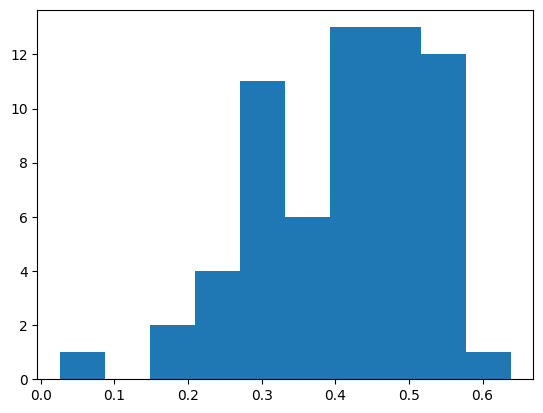

In [47]:
tmp = utils_mindeye.zscore(np.array(all_betas))
# tmp = utils_mindeye.zscore(fmriprep_slicer_betas, train_mean=np.mean(fmriprep_all_betas, axis=0), train_std=np.std(fmriprep_all_betas, axis=0))
corrs, p = vectorized_pearsonr(tmp[:63], offline_betas_norm[:63])
# corrs, p = vectorized_pearsonr(fmriprep_all_betas, fmriprep_slicer_betas)
plt.hist(corrs)
plt.show()

In [68]:
# run nilearn firstlevel glm
from nilearn.glm.first_level import FirstLevelModel

all_betas = []
for run in range(1):
    print(f"Run {run} started")
    events_df = ndscore_events[run]
    tr_labels_hrf = ndscore_tr_labels[run]["tr_label_hrf"].tolist()
    events_df = events_df[events_df['image_name'] != 'blank.jpg']  # must drop blank.jpg after tr_labels_hrf is defined to keep indexing consistent

    for TR in range(192):
        stimulus_trial_counter = np.sum(
            [label != 'blank' for label in tr_labels_hrf[:TR]]
        )  # stimulus_trial_counter is the trial number minus blank trials; this indexes cropped_events which does not contain blank.jpg since we don't model blank trials
        print(f"TR {TR}")
        current_label = tr_labels_hrf[TR]
        print(current_label)
        
        if current_label not in ('blank', 'blank.jpg'):
            # if TR == 183:
            events_df = events_df.copy()
            events_df['onset'] = events_df['onset'].astype(float)

            run_start_time = events_df['onset'].iloc[0]
            events_df = events_df.copy()
            events_df['onset'] -= run_start_time

            cropped_events = events_df[events_df.onset <= TR*tr_length]
            cropped_events = cropped_events.copy()
            print(stimulus_trial_counter)
            print(np.where(cropped_events['trial_number'] == stimulus_trial_counter))
            assert cropped_events['trial_number'].eq(stimulus_trial_counter).any(), "No matching trial_number found in cropped_events"
            cropped_events.loc[:, 'trial_type'] = np.where(cropped_events['trial_number'] == stimulus_trial_counter, "probe", "reference")
            cropped_events = cropped_events.drop(columns=['is_correct', 'image_name', 'response_time', 'trial_number'])

            lss_glm = FirstLevelModel(t_r=tr_length,slice_time_ref=0,hrf_model='glover',
                        drift_model='cosine', drift_order=1,high_pass=0.01,mask_img=union_mask_img,
                        signal_scaling=False,smoothing_fwhm=None,noise_model='ar1',
                        n_jobs=-1,verbose=-1,memory_level=1,minimize_memory=True)

            # lss_glm.fit(run_imgs=mc_data[run].slicer[:,:,:,:TR], events=cropped_events)
            lss_glm.fit(run_imgs=mc_data[run], events=cropped_events)

            dm = lss_glm.design_matrices_[0]
            # get the beta map and mask it
            beta_map = lss_glm.compute_contrast("probe", output_type="effect_size")
            beta_map_np = beta_map.get_fdata()
            beta_map_np = fast_apply_mask(target=beta_map_np,mask=union_mask_img.get_fdata())[0]
            # beta_map_np = np.reshape(beta_map_np, (1,1,19174))
            # pdb.set_trace()
            # beta_map_np = beta_map_np[0,0,union_mask]
            all_betas.append(beta_map_np)

        elif current_label == 'blank.jpg':
            pass
        else:
            assert current_label == 'blank'


Run 0 started
TR 0
blank
TR 1
blank
TR 2
blank
TR 3
blank
TR 4
all_stimuli/unchosen_nsd_1000_images/unchosen_7211_cocoid_59250.png
0
(array([0]),)
TR 5
blank
TR 6
blank
TR 7
all_stimuli/special515/special_67295.jpg
1
(array([1]),)
TR 8
blank
TR 9
blank
TR 10
all_stimuli/unchosen_nsd_1000_images/unchosen_5729_cocoid_53029.png
2
(array([2]),)
TR 11
blank
TR 12
all_stimuli/special515/special_70232.jpg
3
(array([3]),)
TR 13
blank
TR 14
blank
TR 15
all_stimuli/unchosen_nsd_1000_images/unchosen_7251_cocoid_26645.png
4
(array([4]),)
TR 16
blank
TR 17
blank
TR 18
all_stimuli/special515/special_40721.jpg
5
(array([5]),)
TR 19
blank
TR 20
all_stimuli/unchosen_nsd_1000_images/unchosen_1956_cocoid_70856.png
6
(array([6]),)
TR 21
blank
TR 22
blank
TR 23
all_stimuli/unchosen_nsd_1000_images/unchosen_2840_cocoid_40668.png
7
(array([7]),)
TR 24
blank
TR 25
blank
TR 26
all_stimuli/special515/special_23715.jpg
8
(array([8]),)
TR 27
blank
TR 28
blank.jpg
TR 29
blank
TR 30
blank
TR 31
all_stimuli/unchosen

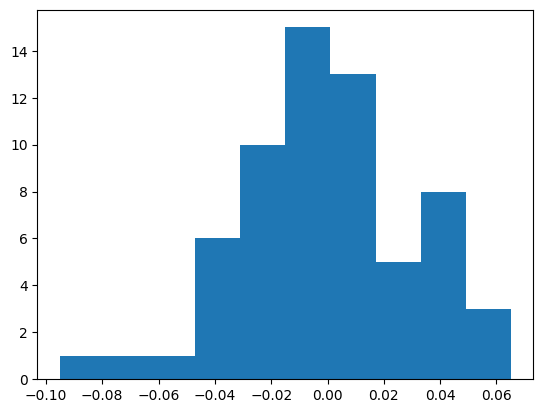

In [70]:
tmp = utils_mindeye.zscore(np.array(all_betas))
corrs, p = vectorized_pearsonr(tmp[:63], offline_betas_norm[:63])
plt.hist(corrs)
plt.show()

In [ ]:
# np.save(f"{derivatives_path}/debugging/betas_run-01_data-fmriprep-all", np.array(all_betas))  # passing in all fmriprep data into the glm on each TR (no slicer)
# np.save(f"{derivatives_path}/debugging/betas_run-01_data-fmriprep-slicer", np.array(all_betas))  # passing in fmriprep data up to each TR (with slicer)

In [ ]:
fmriprep_all_betas = np.load(f"{derivatives_path}/debugging/betas_run-01_data-fmriprep-all.npy")
fmriprep_slicer_betas = np.load(f"{derivatives_path}/debugging/betas_run-01_data-fmriprep-slicer.npy")

In [ ]:
idx = -15
pearsonr(fmriprep_all_betas[idx], fmriprep_slicer_betas[idx])

In [ ]:
np.mean(corrs), np.std(corrs)

In [51]:
designdir = f'{data_path}/design'
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = utils_mindeye.load_design_files(
    sub='sub-005',
    session='ses-03',
    func_task_name='C',
    designdir=designdir,
    design_ses_list=['ses-03']
)

design_list = []
filename = f"{designdir}/csv/sub-005_ses-03.csv"
print(f"Processing design matrix for: {filename}")

# Get data for this session
data, starts, images, is_new_run, image_names = utils_mindeye.process_design(filename)

# Create design matrix for this session
design_ses = utils_mindeye.create_design_matrix(
    images=images,
    starts=starts, 
    is_new_run=is_new_run,
    unique_images=unique_images,
    n_runs=11,
    n_trs=192,
    len_unique_images=len_unique_images,
    interval=1.5
)
        
# print(design_ses)
design_list.extend(design_ses)
# Save concatenated design matrix
design = np.array(design_list)
print(design.shape)

Data shape: (780, 126)
Using design file: /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/data/design/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532
Processing design matrix for: /home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/data/design/csv/sub-005_ses-03.csv
(11, 192, 532)


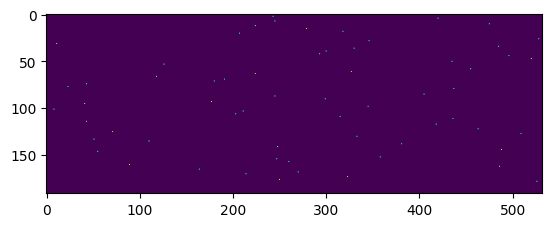

In [52]:
plt.imshow(design[0])
plt.show()

In [53]:
func_data = np.array([x.get_fdata() for x in fmriprep_data])

In [54]:
design.shape, func_data.shape

((11, 192, 532), (11, 76, 90, 74, 192))

In [55]:
func_data = [nilearn.masking.apply_mask(fmriprep_data[i], union_mask_img).T for i in range(n_runs)]

In [56]:
design_list[0].shape, func_data[0].shape

((192, 532), (8627, 192))

In [57]:
func_data[0][:, 0, 0 :10].shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
func_data[0].shape

(8627, 192)

In [84]:
opt = dict()

opt['wantlibrary'] = 0
opt['wantglmdenoise'] = 0
opt['wantfracridge'] = 0
opt['wantfileoutputs'] = [0,0,0,0]
opt['wantmemoryoutputs'] = [0,1,0,0]

glmsingle_obj = GLM_single(opt)
s = time.time()
results_glmsingle = glmsingle_obj.fit(design=design_list[0][:20], data=mc_data_masked[0][:, :20], stimdur=3, tr=tr_length, outputdir=f'{derivatives_path}/glmsingle')
e = time.time()

print(e-s)

*** DIAGNOSTICS ***:
There are 1 runs.
The number of conditions in this experiment is 532.
The stimulus duration corresponding to each trial is 3.00 seconds.
The TR (time between successive data points) is 1.50 seconds.
The number of trials in each run is: [8].
The number of trials for each condition is: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/glmsingle/glmsingle.py:649: UserWarning: Warning: You have specified trial onsets that occur less than 8 seconds from the end of at least one of the runs. This may cause estimation problems! As a solution, consider simply omitting specification of these ending trials from the original design matrix.
  warnings.warn(msg)
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/glmsingle/glmsingle.py:655: UserWarning: None of your conditions occur in more than one run. Are you sure this is what you intend?
  warnings.warn(msg)
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


*** Setting brain R2 threshold to 5.377755468653702 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.87it/s]

*** All model types done ***

*** return model types in results ***

0.6900579929351807


In [85]:
tmp = np.squeeze(results_glmsingle['typeb']['betasmd']).T
print(tmp.shape)

(8, 8627)


In [82]:
print(mc_data[0].shape)
mc_data_masked = [nilearn.masking.apply_mask(mc_data[i], union_mask_img).T for i in range(n_runs)]

(76, 90, 74, 191)


In [83]:
mc_data_masked[0].shape

(8627, 191)

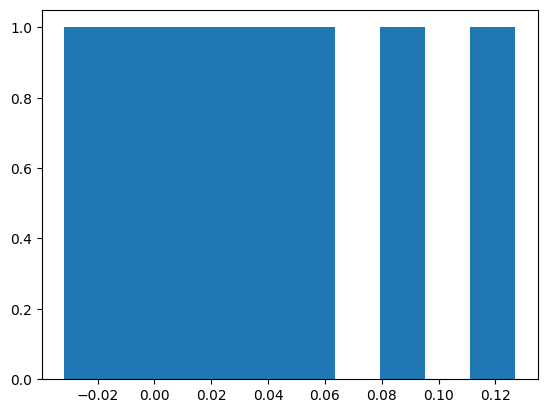

In [86]:
corrs, p = utils_mindeye.vectorized_pearsonr(tmp, offline_betas_norm[:8])
plt.hist(corrs)
plt.show()

In [ ]:
offline_betas_norm.shape, rt_betas_norm.shape

In [ ]:
# correlate these betas with glmsingle betas
betas_path = f'{data_path}/testing/sub-005_ses-03_task-C_bs24_MST_rishab_MSTsplit_union_mask_0_vox.npy'
offline_betas_norm = np.load(betas_path)
fmriprep_betas = np.array(all_betas)
z_mean = np.mean(fmriprep_betas, axis=0)
z_std = np.std(fmriprep_betas, axis=0)
rt_betas_norm = (fmriprep_betas - z_mean) / z_std
# rt_betas_norm = utils_mindeye.zscore(tmp)

# rg = [range(61*i, 63*i) for i in range(1, 2)]
# print(rg)
# indices = [i for r in rg for i in r]
fig, axs = plt.subplots(nrows=int(np.ceil(n_runs / 2)), ncols=2, figsize=(12, 3 * n_runs), constrained_layout=True)
axs = axs.flatten()

n_betas_per_run = 63
for i in range(n_runs):
    start = i * n_betas_per_run
    end = start + n_betas_per_run
    
    correlations, p = vectorized_pearsonr(offline_betas_norm[start:end], rt_betas_norm[:n_betas_per_run])
    
    axs[i].hist(correlations, bins=30, edgecolor='k', alpha=0.7)
    axs[i].set_title(f"Run {i+1}: Mean r={np.mean(correlations):.2f}, Std={np.std(correlations):.2f}")
    axs[i].set_xlabel("Correlation Coefficient")
    axs[i].set_ylabel("Frequency")

    # Print summary statistics
    # print(f"Mean correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
    # print(f"Median correlation: {np.median(correlations):.4f}")
    # print(f"Min correlation: {np.min(correlations):.4f}")
    # print(f"Max correlation: {np.max(correlations):.4f}")

# Hide unused subplots if n_runs is odd
for j in range(i + 1, len(axs)):
    axs[j].axis("off")

fig.suptitle("Distribution of Correlations Between Offline and Real-Time Betas per Run", fontsize=14)
plt.show()

In [ ]:
rt_betas_norm.shape

In [ ]:
all_betas[-1].shape

In [ ]:
tmp = results_glmsingle['typeb']['betasmd'][:,0,0].T
print(tmp.shape, offline_betas_norm.shape)

corrs = vectorized_pearsonr(tmp, offline_betas_norm[:8])
plt.hist(corrs[0])
plt.show()

from statsmodels.stats.multitest import multipletests
print(multipletests(corrs[1], alpha=0.05, method='fdr_bh'))


In [ ]:
tmp = np.load("/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/derivatives/sub-005_ses-03_task-C_run-11_recons/betas_run-11.npy")

In [29]:
b.shape

(693, 8627)

/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ri4541@pu.win.princeton.edu/miniforge3/envs/rt_mindEye2/lib/python3.11/site-packages/numpy/core/_methods.py:198: R

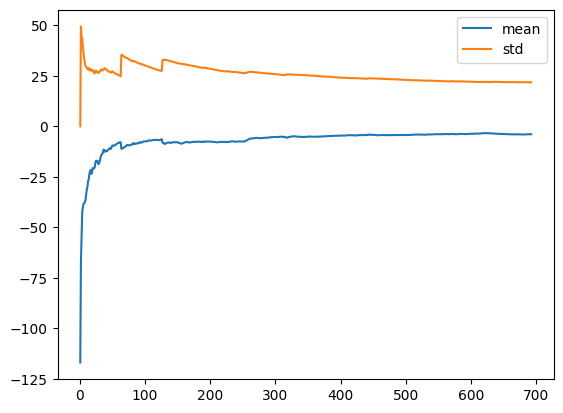

In [32]:
# load betas
b = np.load('/home/ri4541@pu.win.princeton.edu/rtcloud-projects/mindeye/3t/derivatives/debugging/betas_run-01-11_data-realtime-slicer_delay-8.npy')

# calculate the mean and std for b sliced at each condition
v1_mean = []
v1_std = []
for cond in range(b.shape[0]):
    v1_mean.append(np.mean(b[:cond, 0], axis=0))
    v1_std.append(np.std(b[:cond, 0], axis=0))

plt.plot(v1_mean, label='mean')
plt.plot(v1_std, label='std')
plt.legend()
plt.show()